# Explore I06S cruise data

In [1]:
import numpy as np
from numpy.ma import masked_values as maval
import gsw
import xarray as xr
import pandas as pd
import os
import os.path as op
from datetime import datetime, timedelta
from scipy.interpolate import PchipInterpolator as pchip
from scipy.signal import medfilt
import dask.array as dsar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm
import matplotlib.colors as clr
import matplotlib.ticker as tick
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cmocean as cmocean

%matplotlib inline

### Load ancilliary data
We will use this data of bottom topography and climatological frontal locations for plotting.

In [2]:
data_dir ="/Users/dhruvbalwada/OneDrive/sogos_data/"
topo = xr.open_dataarray(
    data_dir+"data/processed/ETOPO1_Ice_g_gmt4_coarsened5.nc"
)

In [3]:
pf = pd.read_csv(
    op.join(data_dir+"data/processed/fronts/pf.txt"),
    delim_whitespace=True,
    header=None,
    dtype=float,
    names=["lon", "lat"],
)
saf = pd.read_csv(
    op.join(data_dir+"data/processed/fronts/saf.txt"),
    delim_whitespace=True,
    header=None,
    dtype=float,
    names=["lon", "lat"],
)

In [4]:
saccf = pd.read_csv(
    op.join(data_dir+"data/processed/fronts/saccf.txt"),
    delim_whitespace=True,
    header=None,
    dtype=float,
    names=["lon", "lat"],
)

In [5]:
sbdy =  pd.read_csv(
    op.join(data_dir+"data/processed/fronts/sbdy.txt"),
    delim_whitespace=True,
    nrows=1079,
    header=None,
    dtype=float,
    names=["lon", "lat"],
)

### Load I06S cruise data
 
Downloaded manually from (https://cchdo.ucsd.edu/cruise/325020190403) 

In [6]:
data_folder = data_dir + "data/raw/cruise/325020190403_nc_ctd/"

In [7]:
file_names = sorted(os.listdir(data_folder))

In [8]:
cruise_dic = {}
for count, fil in enumerate(file_names):
    cruise_dic[count] = xr.open_dataset(data_folder + fil)
    
# each cast from the ship is saved in a different file.
# A cast is a set of measurements made by the ship when it stops one location, 
# lowers instruments off the side, and measure variables. Often these casts are done from
# the surface of the ocean to the bottom. 

In [9]:
# here is the data present at a single location
cruise_dic[0]

<xarray.Dataset>
Dimensions:          (latitude: 1, longitude: 1, pressure: 261, time: 1)
Coordinates:
  * pressure         (pressure) float64 0.0 2.0 4.0 6.0 ... 516.0 518.0 520.0
  * time             (time) datetime64[ns] 2019-04-16T02:07:00
  * latitude         (latitude) float32 -68.3422
  * longitude        (longitude) float32 31.535
Data variables:
    pressure_QC      (pressure) int16 ...
    temperature      (pressure) float64 ...
    temperature_QC   (pressure) int16 ...
    salinity         (pressure) float64 ...
    salinity_QC      (pressure) int16 ...
    oxygen           (pressure) float64 ...
    oxygen_QC        (pressure) int16 ...
    CTDXMISS         (pressure) float64 ...
    CTDXMISS_QC      (pressure) int16 ...
    CTDFLUOR         (pressure) float64 ...
    CTDFLUOR_QC      (pressure) int16 ...
    CTDBBP700RAW     (pressure) float64 ...
    CTDBBP700RAW_QC  (pressure) int16 ...
    woce_date        (time) int32 ...
    woce_time        (time) int16 ...
    station          |S40 ...
    cast             |S40 ...
Attributes:
    EXPOCODE:                   325020190403
    Conventions:                COARDS/WOCE
    WOCE_VERSION:               3.0
    WOCE_ID:                    I06S
    DATA_TYPE:                  WOCE CTD
    STATION_NUMBER:             1
    CAST_NUMBER:                1
    BOTTOM_DEPTH_METERS:        529
    Creation_Time:              2019-06-28T16:39:29.096228Z
    ORIGINAL_HEADER:            CTD,20190628CCHSIO\n# SHIP: Thomas G. Thompso...
    WOCE_CTD_FLAG_DESCRIPTION:  ::1 = Not calibrated:2 = Acceptable measureme...

### Start making some exploratory plots

In [10]:
lat = [cruise_dic[key].latitude.values[0] for key in cruise_dic.keys()]
lon = [cruise_dic[key].longitude.values[0] for key in cruise_dic.keys()]
time = [cruise_dic[key].time.values[0] for key in cruise_dic.keys()]
max_pres = [cruise_dic[key].pressure.max().values for key in cruise_dic.keys()]
len_pres = [len(cruise_dic[key].pressure) for key in cruise_dic.keys()]

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


Text(0.5, 1.0, 'I06 2019 Cruise Track')

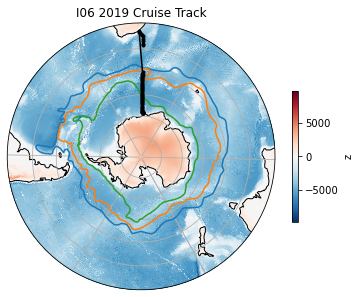

In [11]:
# Where was the cruise?
fig = plt.figure(figsize=(6, 6))
fig.set_tight_layout(True)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(central_longitude=29))
ax.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())

# make a circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Some decoration
ax.add_feature(cfeature.LAND)
ax.coastlines()
# ax.add_feature(cfeature.OCEAN)
ax.gridlines()

topo.sel(y=slice(-90, -30)).plot(
    ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.4}
)

plt.plot(saf.lon, saf.lat, transform=ccrs.PlateCarree())
plt.plot(pf.lon, pf.lat, transform=ccrs.PlateCarree())
#plt.plot(saccf.lon, saccf.lat, transform=ccrs.PlateCarree())
plt.plot(sbdy.lon, sbdy.lat, transform=ccrs.PlateCarree())

ax.plot(lon, lat, transform=ccrs.PlateCarree(), Marker=".", color="k")
plt.title("I06 2019 Cruise Track")

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


Text(0.5, 1.0, 'I06 2019 Cruise Track')

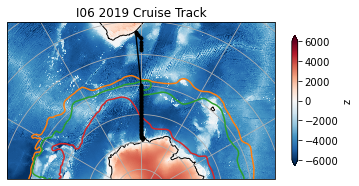

In [12]:
# A zoom in of the cruise region
fig = plt.figure(figsize=(6, 6))
fig.set_tight_layout(True)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(central_longitude=30))
ax.set_extent([-20, 80, -80, -30], ccrs.PlateCarree())

# make a circular boundary

# Some decoration
ax.add_feature(cfeature.LAND)
ax.coastlines()
# ax.add_feature(cfeature.OCEAN)
ax.gridlines()

xsel = slice(-20, 80)
ysel = slice(-80, -30)
topo.sel(y=slice(-90, -10)).plot(
    vmin=-6000, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.4}
)

plt.plot(saf.lon, saf.lat, transform=ccrs.PlateCarree(), color='C1')
plt.plot(pf.lon, pf.lat, transform=ccrs.PlateCarree(), color='C2')
#plt.plot(saccf.lon, saccf.lat, transform=ccrs.PlateCarree())
plt.plot(sbdy.lon, sbdy.lat, transform=ccrs.PlateCarree(), color='C3')

ax.plot(lon, lat, transform=ccrs.PlateCarree(), Marker=".", color="k")

plt.title("I06 2019 Cruise Track")

Text(0.5, 1.0, 'I06 2019 Cruise Track')

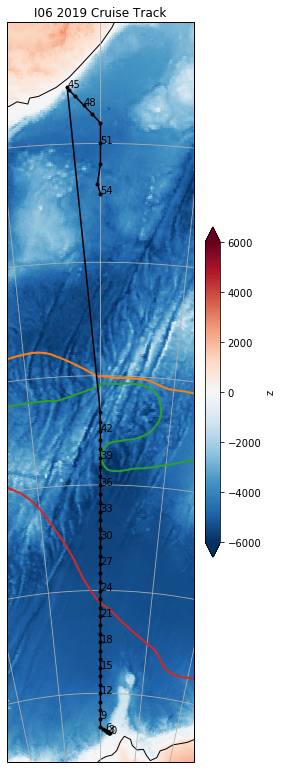

In [16]:
# Further Zoom in
fig = plt.figure(figsize=(4, 12))
fig.set_tight_layout(True)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(central_longitude=30))
ax.set_extent([25, 35, -70, -30], ccrs.PlateCarree())

# make a circular boundary

# Some decoration
ax.add_feature(cfeature.LAND)
ax.coastlines()
# ax.add_feature(cfeature.OCEAN)
ax.gridlines()

xsel = slice(-20, 80)
ysel = slice(-80, -30)
topo.sel(y=slice(-90, -10)).plot(
    vmin=-6000, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={"shrink": 0.4}
)

plt.plot(saf.lon, saf.lat, transform=ccrs.PlateCarree(), linewidth=2, color='C1')
plt.plot(pf.lon, pf.lat, transform=ccrs.PlateCarree(), linewidth=2, color='C2')
#plt.plot(saccf.lon, saccf.lat, transform=ccrs.PlateCarree())
plt.plot(sbdy.lon, sbdy.lat, transform=ccrs.PlateCarree(), linewidth=2, color='C3')

ax.plot(lon, lat, transform=ccrs.PlateCarree(), Marker=".", color="k")

for i in range(0, len(lat), 3):
    ax.text(lon[i], lat[i], i, transform=ccrs.PlateCarree(), color="k")

plt.title("I06 2019 Cruise Track")

### Let's plot some variables

In [11]:
# The choices made here are arbitrary to some degree, and mostly for qualitative purposes. 

# find max pressure that is observed by any of the casts
Pmax = max(max_pres)

# now make a dummy variable from the surface to the deepest point that is measured,
# with some set 
Pint = np.linspace(0, Pmax, int(Pmax / 2) + 1)

In [12]:
# Calculate some Gibbs Sea Water (GSW) variables
# There are some oceanographic variables (SA, CT and sigma0) that are not measured directly,
# but are instead estimated using a package called gsw. 

for i in cruise_dic.keys():
    cruise_dic[i] = xr.merge(
        [
            cruise_dic[i],
            xr.DataArray(
                gsw.SA_from_SP(
                    cruise_dic[i].salinity,
                    cruise_dic[i].pressure,
                    cruise_dic[i].longitude,
                    cruise_dic[i].latitude,
                ),
                dims="pressure",
            ).rename("SA"),
        ]
    )

    cruise_dic[i] = xr.merge(
        [
            cruise_dic[i],
            xr.DataArray(
                gsw.CT_from_t(
                    cruise_dic[i].SA, cruise_dic[i].temperature, cruise_dic[i].pressure
                ),
                dims="pressure",
            ).rename("CT"),
        ]
    )

    cruise_dic[i] = xr.merge(
        [
            cruise_dic[i],
            xr.DataArray(
                gsw.sigma0(cruise_dic[i].SA, cruise_dic[i].CT), dims="pressure"
            ).rename("sigma0"),
        ]
    )

In [13]:
# Since different casts might make measurements at slightly different locations in depth, and also
# because there might be missing points (when QC - quality control - flag is not 2), we 
# interpolate the data to a uniform pressure grid.
# This is primarily for plotting purposes. 

Tint = np.stack(
    [
        cruise_dic[key]
        .CT.where(cruise_dic[key].temperature_QC == 2)
        .interp(pressure=Pint)
        .values
        for key in cruise_dic.keys()
    ],
    axis=0,
)
Sint = np.stack(
    [
        cruise_dic[key]
        .SA.where(cruise_dic[key].salinity_QC == 2)
        .interp(pressure=Pint)
        .values
        for key in cruise_dic.keys()
    ],
    axis=0,
)
sigma0int = np.stack(
    [
        cruise_dic[key]
        .sigma0.where(cruise_dic[key].salinity_QC == 2)
        .interp(pressure=Pint)
        .values
        for key in cruise_dic.keys()
    ],
    axis=0,
)
OXYint = np.stack(
    [
        cruise_dic[key]
        .oxygen.where(cruise_dic[key].oxygen_QC == 2)
        .interp(pressure=Pint)
        .values
        for key in cruise_dic.keys()
    ],
    axis=0,
)
FLUORint = np.stack(
    [
        cruise_dic[key]
        .CTDFLUOR.where(cruise_dic[key].CTDFLUOR_QC == 1)
        .interp(pressure=Pint)
        .values
        for key in cruise_dic.keys()
    ],
    axis=0,
)
BBPint = np.stack(
    [
        cruise_dic[key]
        .CTDBBP700RAW.where(cruise_dic[key].CTDBBP700RAW_QC == 1)
        .interp(pressure=Pint)
        .values
        for key in cruise_dic.keys()
    ],
    axis=0,
)

In [14]:
# now we convert these variables to an xarray dataset, since it makes it easier to plot. 
cruise_ds_int = xr.Dataset(
    {
        "temperature": (["cast_num", "pressure"], Tint),
        "salinity": (["cast_num", "pressure"], Sint),
        "oxygen": (["cast_num", "pressure"], OXYint),
        "fluor": (["cast_num", "pressure"], FLUORint),
        "BBP": (["cast_num", "pressure"], BBPint),
        "sigma0": (["cast_num", "pressure"], sigma0int),
    },
    coords={
        "lon": (["cast_num"], lon),
        "lat": (["cast_num"], lat),
        "time": (["cast_num"], time),
        "pressure": (["pressure"], Pint),
    },
)

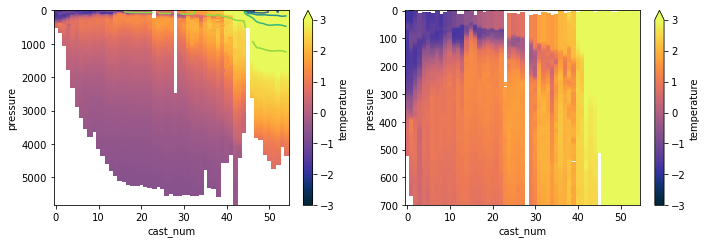

In [17]:
# Now lets try to make some plots and see
plt.figure(figsize=(10, 3.5))

plt.subplot(121)
cruise_ds_int.temperature.T.plot(vmax=3, cmap=cmocean.cm.thermal)
cruise_ds_int.sigma0.T.plot.contour()
plt.gca().invert_yaxis()

plt.subplot(122)
cruise_ds_int.sel(pressure=slice(0, 700)).temperature.T.plot(
    vmax=3, cmap=cmocean.cm.thermal
)
plt.gca().invert_yaxis()
plt.tight_layout()

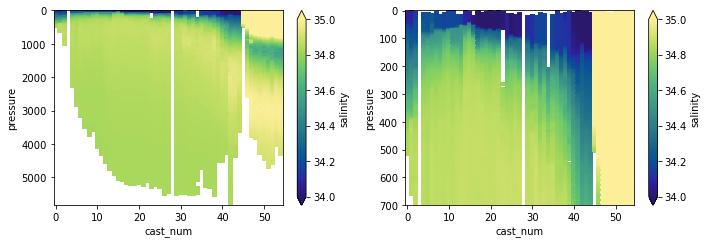

In [17]:
plt.figure(figsize=(10, 3.5))

plt.subplot(121)
cruise_ds_int.salinity.T.plot(vmin=34, vmax=35, cmap=cmocean.cm.haline)
plt.gca().invert_yaxis()

plt.subplot(122)
cruise_ds_int.sel(pressure=slice(0, 700)).salinity.T.plot(
    vmin=34, vmax=35, cmap=cmocean.cm.haline
)
plt.gca().invert_yaxis()
plt.tight_layout()

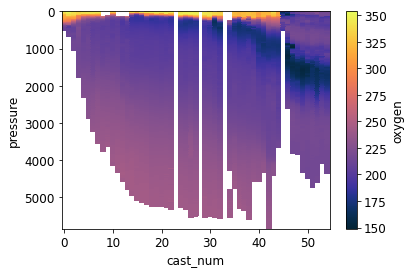

In [26]:
cruise_ds_int.oxygen.T.plot(cmap=cmocean.cm.thermal)
#cruise_ds_int.Oxy_int.T.plot.contour()
plt.gca().invert_yaxis()

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


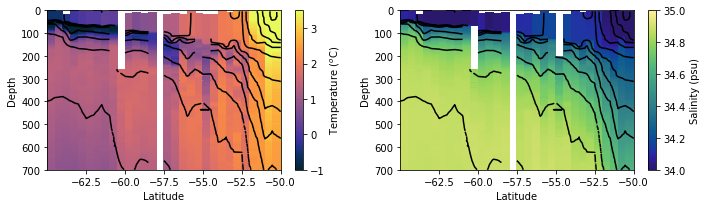

In [18]:
plt.figure(figsize=(10, 3))

n1 =14 
n2 = 45

plt.subplot(121)
plt.pcolormesh(cruise_ds_int.lat.isel(cast_num=slice(n1,n2)),
               cruise_ds_int.pressure.sel(pressure=slice(0,700)),
               cruise_ds_int.temperature.T.isel(cast_num=slice(n1,n2)).sel(pressure=slice(0,700)),
               vmin=-1, vmax=3.5, cmap=cmocean.cm.thermal, rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Temperature ($^o$C)')
plt.contour(cruise_ds_int.lat.isel(cast_num=slice(n1,n2)),
               cruise_ds_int.pressure.sel(pressure=slice(0,700)),
               cruise_ds_int.sigma0.T.isel(cast_num=slice(n1,n2)).sel(pressure=slice(0,700)),
                levels=12, colors='k')
plt.xlabel('Latitude')
plt.ylabel('Depth')
plt.gca().invert_yaxis()

plt.subplot(122)
plt.pcolormesh(cruise_ds_int.lat.isel(cast_num=slice(n1,n2)),
               cruise_ds_int.pressure.sel(pressure=slice(0,700)),
               cruise_ds_int.salinity.T.isel(cast_num=slice(n1,n2)).sel(pressure=slice(0,700)),
               vmin=34, vmax=35, cmap=cmocean.cm.haline, rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Salinity (psu)')
plt.contour(cruise_ds_int.lat.isel(cast_num=slice(n1,n2)),
               cruise_ds_int.pressure.sel(pressure=slice(0,700)),
               cruise_ds_int.sigma0.T.isel(cast_num=slice(n1,n2)).sel(pressure=slice(0,700)),
                levels=12, colors='k')
plt.gca().invert_yaxis()
plt.xlabel('Latitude')
plt.ylabel('Depth')
plt.tight_layout()
#plt.savefig('TSsigma_I6.pdf')

# note how the axis is changed here.

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if __name__ == '__main__':


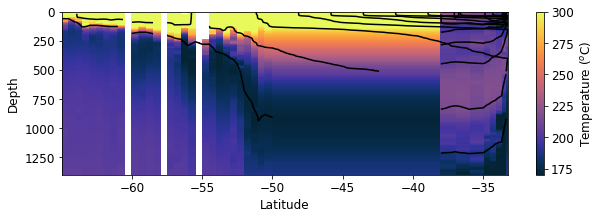

In [32]:
plt.figure(figsize=(10, 3))

n1 =14 
n2 = 54

plt.pcolormesh(cruise_ds_int.lat.isel(cast_num=slice(n1,n2)),
               cruise_ds_int.pressure.sel(pressure=slice(0,1400)),
               cruise_ds_int.oxygen.T.isel(cast_num=slice(n1,n2)).sel(pressure=slice(0,1400)),
               vmin=170, vmax=300, cmap=cmocean.cm.thermal, rasterized=True)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Temperature ($^o$C)')
plt.contour(cruise_ds_int.lat.isel(cast_num=slice(n1,n2)),
               cruise_ds_int.pressure.sel(pressure=slice(0,1400)),
               cruise_ds_int.sigma0.T.isel(cast_num=slice(n1,n2)).sel(pressure=slice(0,1400)),
                levels=12, colors='k')
plt.xlabel('Latitude')
plt.ylabel('Depth')
plt.gca().invert_yaxis()

In [19]:
# Sometimes oceanographers like to plot measurements on a temperature-salinity axis. 
# This is done because it provides insights into where the water might have come from, 
# or how well it is mixing, or if there are fronts present etc. 

# We can do this as follows:

# make a gridded density (Sigma0) for  plotting on TS plots
Tpts = np.linspace(-3, 20, 40)
Spts = np.linspace(33.5, 36, 41)
[Tg, Sg] = np.meshgrid(Tpts, Spts)
rhoTS = gsw.sigma0(Sg, Tg)

(-2.0, 6.0)

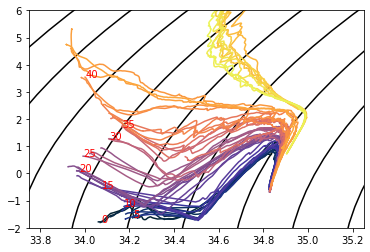

In [20]:
plt.contour(Sg, Tg, rhoTS, levels=30, colors="k")
ncasts = len(cruise_ds_int.cast_num)
for n in range(ncasts):
    plt.plot(
        cruise_ds_int.isel(cast_num=n).salinity.T,
        cruise_ds_int.isel(cast_num=n).temperature.T,
        color=cmocean.cm.thermal(n / ncasts),
    )

for n in range(0, 44, 5):
    plt.text(
        cruise_ds_int.isel(cast_num=n).salinity[10],
        cruise_ds_int.isel(cast_num=n).temperature[10],
        n,
        color="r",
    )

plt.xlim([33.75, 35.25])
plt.ylim([-2, 6])

In [18]:
cruise_ds_int.BBP

<xarray.DataArray 'BBP' (cast_num: 55, pressure: 2921)>
array([[      nan,       nan, 1.669e-01, ...,       nan,       nan,
              nan],
       [      nan, 1.000e-04, 1.000e-04, ...,       nan,       nan,
              nan],
       [      nan,       nan, 2.044e-01, ...,       nan,       nan,
              nan],
       ...,
       [      nan,       nan, 2.357e-01, ...,       nan,       nan,
              nan],
       [      nan, 1.884e-01, 1.888e-01, ...,       nan,       nan,
              nan],
       [      nan,       nan, 1.965e-01, ...,       nan,       nan,
              nan]])
Coordinates:
    lon       (cast_num) float32 31.535 31.395 31.32178 ... 29.8081 30.00146
    lat       (cast_num) float32 -68.3422 -68.35402 ... -38.01492 -38.49942
    time      (cast_num) datetime64[ns] 2019-04-16T02:07:00 ... 2019-05-11T10...
  * pressure  (pressure) float64 0.0 2.0 4.0 ... 5.836e+03 5.838e+03 5.84e+03
Dimensions without coordinates: cast_num

/Users/dhruvbalwada/code/miniconda/envs/sogos/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


(-60.0, -50.0)

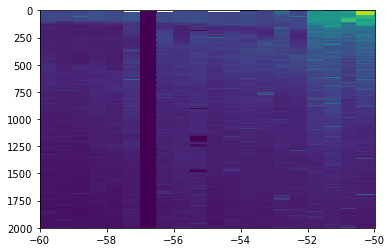

In [19]:
plt.pcolormesh(cruise_ds_int.lat, cruise_ds_int.pressure, cruise_ds_int.BBP.T, vmin=0.12, vmax=0.24)
plt.gca().invert_yaxis()
plt.ylim(2000,0)
plt.xlim(-60,-50)

In [15]:
from scipy.signal import medfilt
from scipy.ndimage import  minimum_filter1d, maximum_filter1d

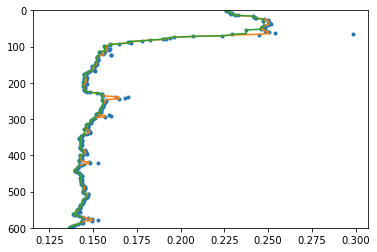

In [79]:
plt.plot(cruise_dic[10].CTDBBP700RAW, cruise_dic[10].pressure, '.')
plt.plot(medfilt(cruise_dic[10].CTDBBP700RAW,5), cruise_dic[10].pressure)
plt.plot(maximum_filter1d(minimum_filter1d(cruise_dic[10].CTDBBP700RAW,7),7), cruise_dic[10].pressure)
plt.ylim(0,600)

plt.gca().invert_yaxis()


In [16]:

for i in cruise_dic.keys():
    cruise_dic[i] = xr.merge(
        [
            cruise_dic[i],
            xr.DataArray(
                maximum_filter1d(minimum_filter1d(cruise_dic[i]
                        .CTDBBP700RAW.where(cruise_dic[i].CTDBBP700RAW_QC == 1),7),7)
                 ,
                dims="pressure",
            ).rename("BBP_despiked"),
        ]
    )

In [17]:
BBP_despiked_int = np.stack(
    [
        cruise_dic[key].BBP_despiked
        .interp(pressure=Pint)
        .values
        for key in cruise_dic.keys()
    ],
    axis=0,
)

In [18]:
cruise_ds_int = xr.Dataset(
    {
        "temperature": (["cast_num", "pressure"], Tint),
        "salinity": (["cast_num", "pressure"], Sint),
        "oxygen": (["cast_num", "pressure"], OXYint),
        "fluor": (["cast_num", "pressure"], FLUORint),
        "BBP": (["cast_num", "pressure"], BBPint),
        "BBP_despiked": (["cast_num", "pressure"], BBP_despiked_int),
        "sigma0": (["cast_num", "pressure"], sigma0int),
    },
    coords={
        "lon": (["cast_num"], lon),
        "lat": (["cast_num"], lat),
        "time": (["cast_num"], time),
        "pressure": (["pressure"], Pint),
    },
)

In [19]:
cruise_ds_int

<xarray.Dataset>
Dimensions:       (cast_num: 55, pressure: 2921)
Coordinates:
    lon           (cast_num) float32 31.535 31.395 31.32178 ... 29.8081 30.00146
    lat           (cast_num) float32 -68.3422 -68.35402 ... -38.01492 -38.49942
    time          (cast_num) datetime64[ns] 2019-04-16T02:07:00 ... 2019-05-1...
  * pressure      (pressure) float64 0.0 2.0 4.0 ... 5.838e+03 5.84e+03
Dimensions without coordinates: cast_num
Data variables:
    temperature   (cast_num, pressure) float64 nan nan -1.803 ... nan nan nan
    salinity      (cast_num, pressure) float64 nan nan 34.07 ... nan nan nan
    oxygen        (cast_num, pressure) float64 nan nan 343.4 ... nan nan nan
    fluor         (cast_num, pressure) float64 nan nan 0.1148 ... nan nan nan
    BBP           (cast_num, pressure) float64 nan nan 0.1669 ... nan nan nan
    BBP_despiked  (cast_num, pressure) float64 0.1669 0.1669 0.1669 ... nan nan
    sigma0        (cast_num, pressure) float64 nan nan 27.3 27.3 ... nan nan nan

In [20]:
import matplotlib

In [21]:
font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

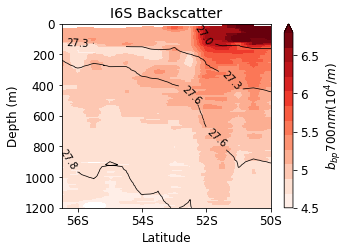

In [23]:
plt.figure(figsize=(5,3.5))
plt.contourf(cruise_ds_int.lat.isel(cast_num=slice(31,45)), 
             cruise_ds_int.pressure.sel(pressure=slice(0,1200)), 
             cruise_ds_int.BBP_despiked.isel(cast_num=slice(31,45)).sel(pressure=slice(0,1200)).T/280, 
             levels=np.linspace(4.5,6.8,13)*1e-4,
            extend='max', cmap='Reds')
plt.gca().invert_yaxis()
cbar = plt.colorbar(ticks = np.array([4.5, 5, 5.5, 6, 6.5])*1e-4)
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.set_yticklabels([4.5, 5, 5.5, 6, 6.5]) 
cbar.ax.set_ylabel(r'$b_{bp}700 nm (10^{4}/m)$')
plt.xticks([-56, -54, -52, -50], labels=['56S', '54S', '52S', '50S'])

CS = plt.contour(cruise_ds_int.lat.isel(cast_num=slice(31,45)),
            cruise_ds_int.pressure.sel(pressure=slice(0,1200)),
            cruise_ds_int.sigma0.isel(cast_num=slice(31,45)).sel(pressure=slice(0,1200)).T,
                levels=[27, 27.3, 27.6, 27.8], colors='k',
               linewidths=0.75)

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s
CS.levels = [str(nf(val)) for val in CS.levels]    
plt.clabel(CS, CS.levels, inline=True,   fontsize=10)

#plt.ylim(2000,0)
#plt.xlim(-56.5,-50)
plt.xlabel('Latitude')
plt.ylabel('Depth (m)')
plt.tight_layout()
plt.title('I6S Backscatter')
plt.savefig('despiked_backscatter.pdf')